In [1]:
%%capture
%cd ..

In [2]:
from src.dataloader import TimeSeriesGCNNDataset
from torch_geometric.loader import DataLoader
import networkx as nx

import numpy as np
import seaborn as sns
import pandas as pd

np.random.seed(42)  # For reproducible results
sns.set_theme("notebook", style="darkgrid", palette="flare")

WINDOW_SIZE = 60
HIDDEN_LAYER = 1024
TARGET_SIZE = 1
GRANULARITY = 12 # 5 minutes


# Understanding the data
The most complex and crucial task for this modelling is going to be to understand how the raw data is organized and how to format the training data.

### Raw data

In [3]:
raw_data_features = np.load("data/PEMS08/pems08.npz")["data"]
raw_data_features.shape 

(17856, 170, 3)

In [4]:
distance_matrix = pd.read_csv("data/PEMS08/distance.csv")
distance_matrix

,from,to,cost
0,9,153,310.6
1,153,62,330.9
2,62,111,332.9
3,111,11,324.2
4,11,28,336.0
...,...,...,...
290,154,5,166.3
291,78,107,143.9
292,107,46,236.3
293,118,145,250.6


above you can see the shape of the raw data. This is a numpy array with the following dimension:
- First Dimension (Time, 17856 obs): Represents different time steps in the dataset. Each "slice" of this dimension is a snapshot of the entire graph (e.g., traffic network) at a specific time.

- Second Dimension (Vertices/Nodes, 170 obs): Corresponds to the vertices or nodes in the graph. In this context, each node represent a different sensor within the traffic network.

- Third Dimension (Features, 3): Contains features or measurements for each vertex at each time step. The feature of this dataset are: **total flow**, **average occupancy** and **average speed**

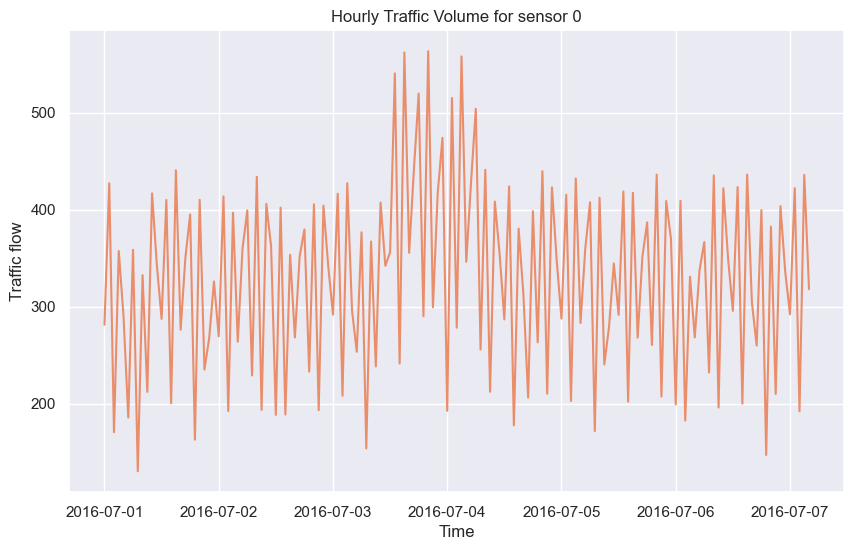

In [5]:
from src.viz import viz_ts
import pandas as pd

traffic_flow = raw_data_features[:, 0, 0]
timepoints = pd.date_range(start='2016-07-01', periods=len(traffic_flow), freq='30s')

df = pd.DataFrame({'Traffic Volume': traffic_flow}, index=timepoints)

hourly_df = df.resample('h').mean()

hourly_traffic_flow = hourly_df['Traffic Volume'].values
hourly_timepoints = hourly_df.index

viz_ts(hourly_traffic_flow, 
       hourly_timepoints, 
       x_label="Time",
       y_label="Traffic flow",
       title="Hourly Traffic Volume for sensor 0")

### Training data
Now we are going to use the custom `TimeSeriesGCNNDataset` class to generate the data in a format suitable for feeding it into a traffic forecasting model.

In [6]:
traffic_dataset = TimeSeriesGCNNDataset(raw_data_features[:, :, 0],
                                        distance_matrix[["from", "to"]].to_numpy(),
                                        distance_matrix[["cost"]].to_numpy(),
                                        window_size=WINDOW_SIZE,
                                        target_size=TARGET_SIZE,
                                        new_granularity=GRANULARITY) #to go from 30s to 1min

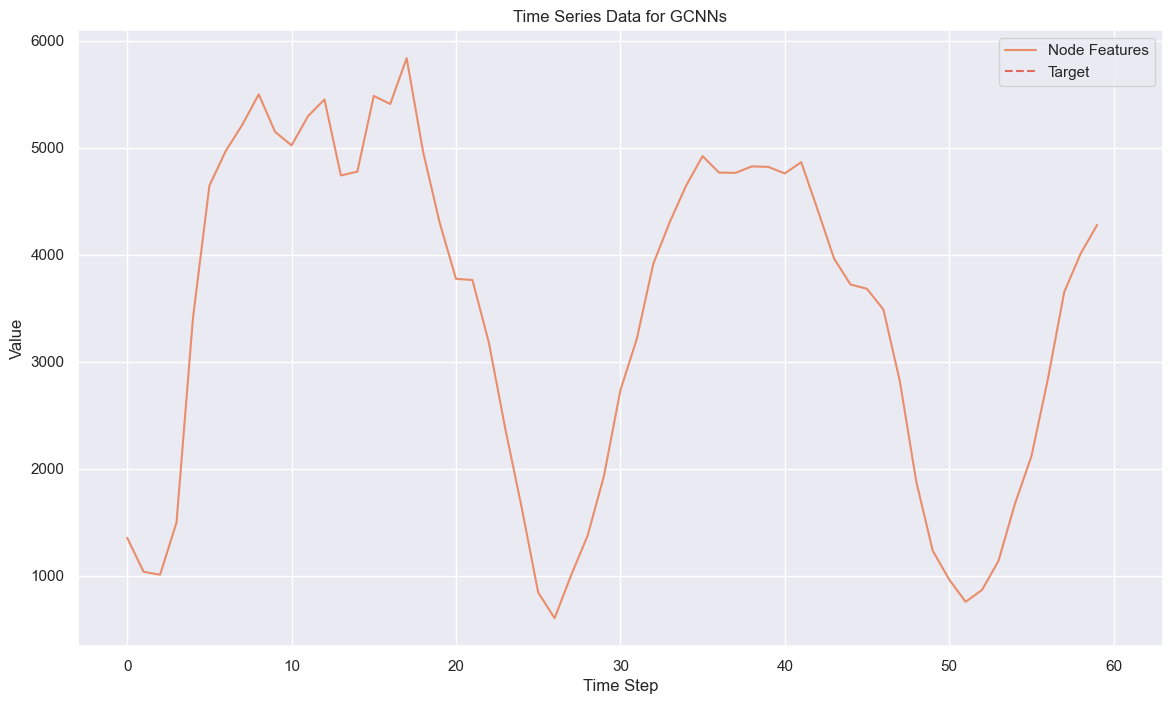

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

node_features = traffic_dataset[0].x
target = traffic_dataset[0].y

# Plotting with Seaborn
plt.figure(figsize=(14, 8))

# Plot the node_features
sns.lineplot(x=range(traffic_dataset.window_size), y=node_features[0, :].flatten(), label='Node Features')

# Plot the target with a different style
sns.lineplot(x=range(traffic_dataset.window_size, traffic_dataset.window_size+traffic_dataset.target_size), y=target[0, :].flatten(), label='Target', linestyle='--')

plt.title('Time Series Data for GCNNs')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


# Training

In [8]:
from src.models import BaselineGCN

model = BaselineGCN(traffic_dataset.window_size, traffic_dataset.target_size, hidden_channels=HIDDEN_LAYER)

In [9]:
data_loader = DataLoader(traffic_dataset, batch_size=64, shuffle=True)

In [10]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the number of epochs
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    # Initialize the progress bar
    pbar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    
    # Initialize the total loss for the epoch
    total_loss = 0
    
    # Iterate over the batches
    for batch in pbar:

        # Move the batch to the device
        batch = batch.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch.x, batch.edge_index, batch.edge_weight)
        
        # Compute the loss
        loss = criterion(output, batch.y)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the total loss
        total_loss += loss.item()
        
        # Update the progress bar description
        pbar.set_postfix({'Loss': total_loss / len(pbar)})
    
    # Print the average loss for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(data_loader)}')


Epoch 1/50:   0%|          | 0/23 [00:00<?, ?batch/s]

Epoch 1/50: 100%|██████████| 23/23 [00:06<00:00,  3.78batch/s, Loss=1.08e+7]


Epoch 1/50, Loss: 10787201.173913043


Epoch 2/50: 100%|██████████| 23/23 [00:03<00:00,  6.32batch/s, Loss=1.07e+7]


Epoch 2/50, Loss: 10742729.304347826


Epoch 3/50: 100%|██████████| 23/23 [00:03<00:00,  7.18batch/s, Loss=1.06e+7]


Epoch 3/50, Loss: 10610783.673913043


Epoch 4/50: 100%|██████████| 23/23 [00:02<00:00,  7.96batch/s, Loss=1.07e+7]


Epoch 4/50, Loss: 10662937.652173912


Epoch 5/50: 100%|██████████| 23/23 [00:02<00:00,  8.05batch/s, Loss=1.08e+7]


Epoch 5/50, Loss: 10791076.217391305


Epoch 6/50: 100%|██████████| 23/23 [00:02<00:00,  7.99batch/s, Loss=1.08e+7]


Epoch 6/50, Loss: 10802032.130434783


Epoch 7/50: 100%|██████████| 23/23 [00:02<00:00,  8.38batch/s, Loss=1.08e+7]


Epoch 7/50, Loss: 10762608.06521739


Epoch 8/50: 100%|██████████| 23/23 [00:02<00:00,  8.13batch/s, Loss=1.07e+7]


Epoch 8/50, Loss: 10728670.913043479


Epoch 9/50: 100%|██████████| 23/23 [00:02<00:00,  8.14batch/s, Loss=1.07e+7]


Epoch 9/50, Loss: 10703945.086956521


Epoch 10/50: 100%|██████████| 23/23 [00:03<00:00,  7.16batch/s, Loss=1.08e+7]


Epoch 10/50, Loss: 10824591.43478261


Epoch 11/50: 100%|██████████| 23/23 [00:02<00:00,  8.01batch/s, Loss=1.06e+7]


Epoch 11/50, Loss: 10635264.47826087


Epoch 12/50: 100%|██████████| 23/23 [00:02<00:00,  7.77batch/s, Loss=1.07e+7]


Epoch 12/50, Loss: 10706301.695652174


Epoch 13/50:  26%|██▌       | 6/23 [00:01<00:03,  4.94batch/s, Loss=2.74e+6]


KeyboardInterrupt: 

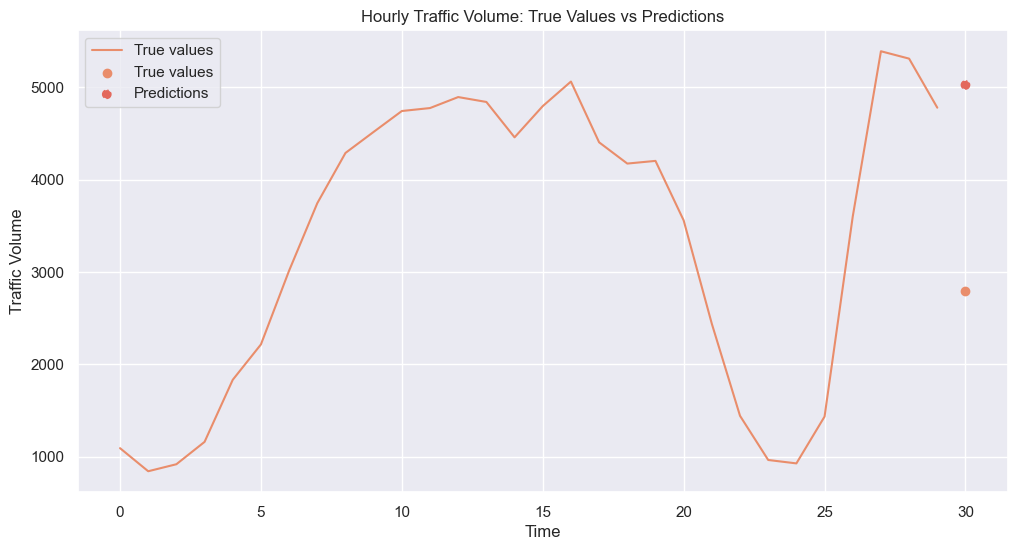

In [ ]:
# Set the model to evaluation mode
model.eval()

# Move the model to the device
model = model.to(device)

# Move the data to the device
batch = batch.to(device)

# Disable gradient computation
with torch.no_grad():
    # Forward pass
    output = model(batch.x, batch.edge_index, batch.edge_weight)

# Move the output and target to the CPU
output = output[0].cpu()
target = batch.y[0].cpu()

# Convert the output and target to numpy arrays
output = output.numpy()
target = target.numpy()

# Plotting the predictions against the true values
plt.figure(figsize=(12, 6))

plt.plot(range(traffic_dataset.window_size), batch.x[0].flatten(), label='True values', linestyle='-')

plt.scatter(range(traffic_dataset.window_size, traffic_dataset.window_size+traffic_dataset.target_size), output[0].flatten(), label='True values', linestyle='-')
plt.scatter(range(traffic_dataset.window_size, traffic_dataset.window_size+traffic_dataset.target_size), batch.y[0].flatten(), label='Predictions', linestyle='-.')
plt.title('Hourly Traffic Volume: True Values vs Predictions')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()
